In [615]:
import pandas as pd
import numpy as np
import glob
from scipy import stats
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

In [491]:
glob.glob('data/tennis_atp-master/atp_matches_[12][019][01298]*')

df = pd.concat([pd.read_csv(i) for i in glob.glob('data/tennis_atp-master/atp_matches_[12][019][01298]*')], axis=0)

df = df.reset_index(drop=True)

Очистим записи, в которых содержится более 30% пропусков.

In [492]:
df = df.dropna(thresh=0.7*df.shape[1], axis=0).reset_index(drop=True)

## Задача 1
а) Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);

Для проведения статистического анализа создадим новые признаки для каждого из игроков: количество победных матчей win_count и количество проигранных матчей lose_count, различие рангов победителя и проигравшего diff_20 (1 - ранг победителя больше более чем на 20 пунктов, 0 - ранг победителя не превосходит ранг проигравшего на 20 пунктов), количество выигранных win_diff_20 и проигранных lose_diff_20 матчей, когда ранг игрока превышал ранг соперника на 20 пунктов и более.

In [533]:
df['win_count'] = df.groupby('winner_id')['winner_id'].transform('count')
df['lose_count'] = df.groupby('loser_id')['loser_id'].transform('count')
df['win_diff_20'] = df['winner_rank'] > df['loser_rank'] + 20
df['lose_diff_20'] = df['loser_rank'] > df['winner_rank'] + 20
df['win_diff_20'] = df[df['win_diff_20'] == 1].groupby('winner_id')['winner_id'].transform('count')
df['lose_diff_20'] = df[df['lose_diff_20'] == 1].groupby('loser_id')['loser_id'].transform('count')

In [534]:
winner = df.groupby('winner_id')[['winner_id', 'win_count', 'win_diff_20']].mean().reset_index(drop=True)
loser = df.groupby('loser_id')[['loser_id', 'lose_count', 'lose_diff_20']].mean().reset_index(drop=True)

Создадим сводную таблицу, в которой содержится id игрока winner_id, количество побед и поражений (win_count и lose_count), доля побед winrate и доля побед winrate_diff_20 в матчах, когда ранг игрока превосходил ранг соперника более, чем на 20 пунктов.

In [535]:
joined = winner.merge(loser, left_on = 'winner_id', right_on='loser_id', how='left')
joined.drop(columns='loser_id', axis= 1 , inplace= True)
joined['winrate'] = joined['win_count'] / (joined['win_count'] + joined['lose_count'])
joined['winrate_diff_20'] = joined['win_diff_20'] / (joined['win_diff_20'] + joined['lose_diff_20'])

Проверим, как распределены признаки общей доли количества побед и доли количества побед, когда ранг игрока превосходил ранг соперника более чем на 20 пунктов.

C:\Temp\ipykernel_9288\3704297618.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined['winrate_diff_20'], label='winrate_diff_20');
C:\Temp\ipykernel_9288\3704297618.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined['winrate'], label='winrate');


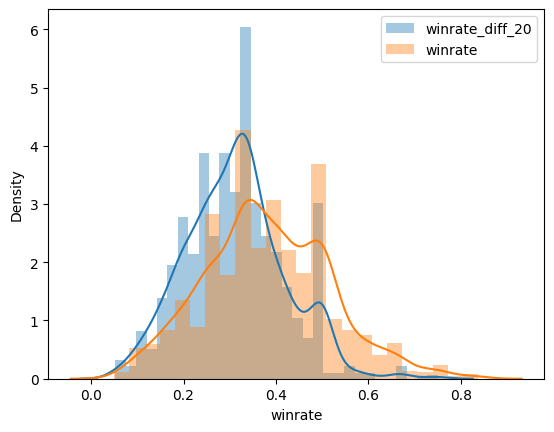

In [539]:
sns.distplot(joined['winrate_diff_20'], label='winrate_diff_20');
sns.distplot(joined['winrate'], label='winrate');
plt.legend();

Признаки не являются распределенными нормально. Поэтому для сравнения выборок используем непараметрический тест Манна-Уитни.

In [543]:
stats.mannwhitneyu(joined['winrate'].dropna(), joined['winrate_diff_20'].dropna(), alternative='greater')

MannwhitneyuResult(statistic=1421976.0, pvalue=8.065630561793119e-48)

Поскольку p-значение меньше 0,05, мы не можем говорить о том, что игрок в среднем победит с большей вероятностью, если его ранг выше ранга соперника на 20 пунктов. Чтобы увидеть результаты более наглядно, построим boxplot двух выборок.

<AxesSubplot: >

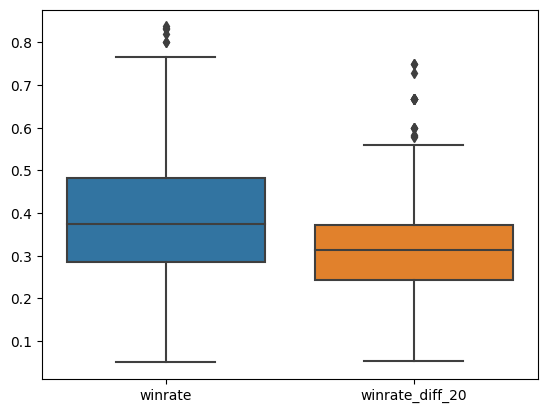

In [553]:
sns.boxplot(data=joined[['winrate', 'winrate_diff_20']]);

Видим, что среднее количество побед для игрока больше, чем среднее количество побед, когда ранг игрока превышает ранг соперника на 20 пунктов.

б) Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

Решим задачу аналогично - создадим выборку, в которой ранг игрока отличается не более чем на 5 пунктов от ранга соперника.

In [554]:
df['diff_5'] = abs(df['winner_rank'] - df['loser_rank']) <= 5
df['win_diff_5'] = df[df['diff_5'] == 1].groupby('winner_id')['winner_id'].transform('count')
df['lose_diff_5'] = df[df['diff_5'] == 1].groupby('loser_id')['loser_id'].transform('count')

In [555]:
winner = df.groupby('winner_id')[['winner_id', 'win_count', 'win_diff_5']].mean().reset_index(drop=True)
loser = df.groupby('loser_id')[['loser_id', 'lose_count', 'lose_diff_5']].mean().reset_index(drop=True)

joined = winner.merge(loser, left_on = 'winner_id', right_on='loser_id', how='left')
joined.drop(columns='loser_id', axis= 1 , inplace= True)
joined['winrate'] = joined['win_count'] / (joined['win_count'] + joined['lose_count'])
joined['winrate_diff_5'] = joined['win_diff_5'] / (joined['win_diff_5'] + joined['lose_diff_5'])

Проверим, как распределены признаки доли побед для игрока:

C:\Temp\ipykernel_9288\3862310313.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined['winrate_diff_5'], label='winrate_diff_5');
C:\Temp\ipykernel_9288\3862310313.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined['winrate'], label='winrate');


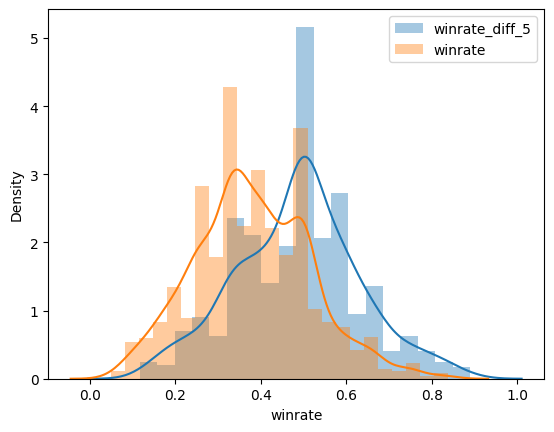

In [556]:
sns.distplot(joined['winrate_diff_5'], label='winrate_diff_5');
sns.distplot(joined['winrate'], label='winrate');
plt.legend();

Снова получили распределение, отличное от нормального - поэтому снова воспользуемся непараметрическим тестом Маана-Уитни.

In [558]:
stats.mannwhitneyu(joined['winrate'].dropna(), joined['winrate_diff_5'].dropna(), alternative='less')

MannwhitneyuResult(statistic=269968.0, pvalue=7.885275468496159e-50)

В данном случае среднее количество побед игрока в тех играх, в которых ранг игроков отличался максимум на 5 пунктов, выше, чем среднее количество побед игрока в общем случае. Т.е. выреятность победы игрока выше, когда его ранг отличается от ранга соперника не более, чем на 5 пунктов. Построим boxplot для более наглядной интерпретации результатов.

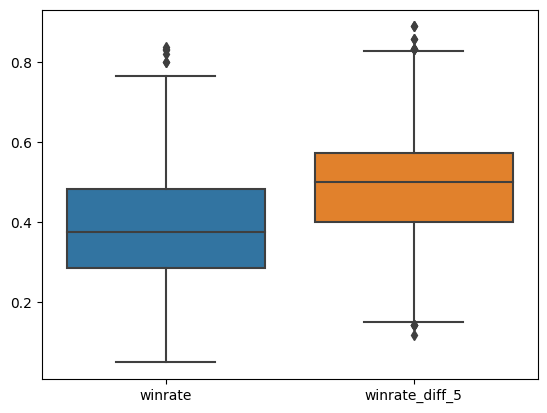

In [560]:
sns.boxplot(data=joined[['winrate', 'winrate_diff_5']]);

Видим, что в среднем игрок побеждает чуть менее чем в 40% игр. Средняя вероятность победы игрока, ранг которого отличается от ранга соперника менее чем на 5 пунктов составляет приблизительно 50%.

# Задание 2

Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

In [582]:
df.loc[:, "tourney_date"] = pd.to_datetime(df["tourney_date"], format="%Y%m%d")

C:\Temp\ipykernel_9288\1486581259.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "tourney_date"] = pd.to_datetime(df["tourney_date"], format="%Y%m%d")


Сформируем 2 датасета: матчи, проводимые до 2001 г и после 2001 года (data_1 и data_2 соотвественно).

In [583]:
data_1 = df[df['tourney_date'].dt.year <= 2001]
data_2 = df[df['tourney_date'].dt.year >= 2002]

Сформируем 2 выборки: среднее количество сетов для каждого игрока для двух указанных периодов.

In [584]:
win_1 = data_1.groupby('winner_id')[['w_ace']].mean().reset_index(drop=True)
win_2 = data_2.groupby('winner_id')[['w_ace']].mean().reset_index(drop=True)

Посмотрим, как распределено среднее количество сетов для игрока для 2 периодов времени.

C:\Temp\ipykernel_9288\156186063.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(win_1, label='win_1');
C:\Temp\ipykernel_9288\156186063.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(win_2, label='win_2');


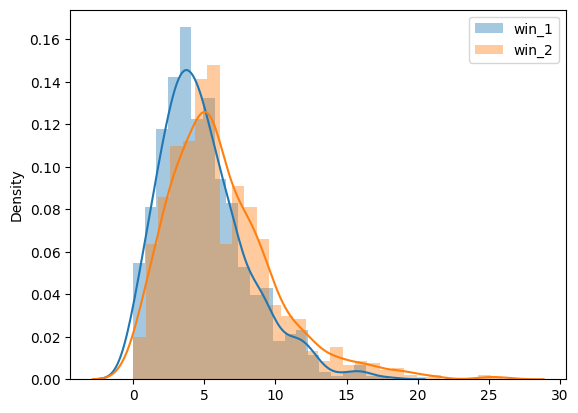

In [585]:
sns.distplot(win_1, label='win_1');
sns.distplot(win_2, label='win_2');
plt.legend();

Выполним тест Шапира-Уилка, чтобы проверить, является ли распределение рассматриваемых признаков нормальным.

In [586]:
print(stats.shapiro(win_1))
print(stats.shapiro(win_2))

ShapiroResult(statistic=0.9444524645805359, pvalue=5.275838944388792e-16)
ShapiroResult(statistic=0.921787679195404, pvalue=6.289209975181345e-23)


Признаки распределены ненормально, из-за чего мы не можем применить t-test. Поэтому для сравнения выборок воспользуемся тестом Уилкоксона. Наши выборки являются сопряженными, т.к. один игрок может попасть в 2 выборки.

In [587]:
stats.wilcoxon(win_1, win_2.iloc[:win_1.shape[0]], alternative='less')

WilcoxonResult(statistic=array([90217.5]), pvalue=array([3.89492871e-15]))

p-значение оказалось меньше 0.05, поэтому мы принимаем альтернативную гипотезу - среднее количество сетов, совершенное победителем во время игры, было меньше в период до 2001.

# Вопрос 3

У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

In [588]:
data_1 = data_1[data_1['best_of'] == 5]
data_2 = data_2[data_2['best_of'] == 5]

win_1 = data_1.groupby('winner_id')[['w_ace']].mean().reset_index(drop=True)
win_2 = data_2.groupby('winner_id')[['w_ace']].mean().reset_index(drop=True)

Проверим распределение сетов, совершенных победителем за игру:

C:\Temp\ipykernel_9288\156186063.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(win_1, label='win_1');
C:\Temp\ipykernel_9288\156186063.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(win_2, label='win_2');


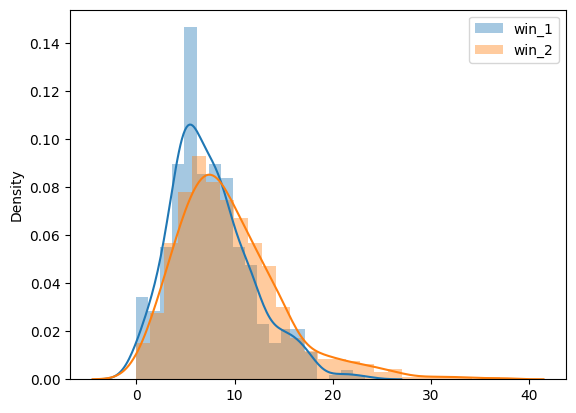

In [589]:
sns.distplot(win_1, label='win_1');
sns.distplot(win_2, label='win_2');
plt.legend();

Выполним тест Шапиро-Уилка, чтобы проверить признаки на нормальность:

In [590]:
print(stats.shapiro(win_1))
print(stats.shapiro(win_2))

ShapiroResult(statistic=0.9623531103134155, pvalue=5.1372590625931025e-09)
ShapiroResult(statistic=0.9257716536521912, pvalue=1.7423641432949594e-17)


Признаки расределены ненормально - воспользуемся тестом Уилкоксона для ненормально распределенных парных выборок.

In [591]:
stats.wilcoxon(win_1, win_2.iloc[:win_1.shape[0]], alternative='less')

WilcoxonResult(statistic=array([31144.5]), pvalue=array([1.81873628e-08]))

p-значение меньше 0.05, т.е. принимаем альтернативную гипотезу - среднее количество сетов, сделанное победителем за игру, до 2001 года было меньше.

## Задача 4
Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис. Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

Ранги игроков Younes El Aynaoui и Ze Zhang примерно одинаковы, ранг игрока Andrei Medvedev выше в 2 раза.

Выберем те матчи, в которых учавствовали указанные игроки и разделим их на отдельные датасеты.

In [ ]:
player_1 = df[(df['winner_name'] == 'Younes El Aynaoui') | (df['loser_name'] == 'Younes El Aynaoui')].reset_index(drop=True)
player_2 = df[(df['winner_name'] == 'Andrei Medvedev') | (df['loser_name'] == 'Andrei Medvedev')].reset_index(drop=True)
player_3 = df[(df['winner_name'] == 'Ze Zhang') | (df['loser_name'] == 'Ze Zhang')].reset_index(drop=True)

Создадим для каждого игрока признак win/lose (1 - рассматриваемый игрок выиграл, 0 - проиграл).

In [ ]:
player_1['win/lose'] = player_1['winner_name'].apply(lambda x: 1 if x=='Younes El Aynaoui' else 0)
player_2['win/lose'] = player_2['winner_name'].apply(lambda x: 1 if x=='Andrei Medvedev' else 0)
player_3['win/lose'] = player_3['winner_name'].apply(lambda x: 1 if x=='Ze Zhang' else 0)

Теперь посчитаем долю выигранных брейкпоинтов для каждого игрока bp

In [ ]:
player_1['saved'] = player_1['w_bpSaved']*player_1['win/lose'] + player_1['l_bpSaved']*(1-player_1['win/lose'])
player_1['faced'] = player_1['w_bpFaced']*player_1['win/lose'] + player_1['l_bpFaced']*(1-player_1['win/lose'])
player_1['bp'] = player_1['saved'] / (player_1['saved'] + player_1['faced'])

player_2['saved'] = player_2['w_bpSaved']*player_2['win/lose'] + player_2['l_bpSaved']*(1-player_2['win/lose'])
player_2['faced'] = player_2['w_bpFaced']*player_2['win/lose'] + player_2['l_bpFaced']*(1-player_2['win/lose'])
player_2['bp'] = player_2['saved'] / (player_2['saved'] + player_2['faced'])

player_3['saved'] = player_3['w_bpSaved']*player_3['win/lose'] + player_3['l_bpSaved']*(1-player_3['win/lose'])
player_3['faced'] = player_3['w_bpFaced']*player_3['win/lose'] + player_3['l_bpFaced']*(1-player_3['win/lose'])
player_3['bp'] = player_3['saved'] / (player_3['saved'] + player_3['faced'])

In [ ]:
player_1['year'] = player_1['tourney_date'].dt.year
player_2['year'] = player_2['tourney_date'].dt.year
player_3['year'] = player_3['tourney_date'].dt.year

Сгруппируем данные о наших игроках по годам и вычислим среднее значение выигранных брейкпоинтов в тех матчах, в которых игрок побеждал. Объединим данные в таблицу winners, в которой будет содержаться информация об игроках и среднем количестве выигранных брейкпоинтов по годам. Во всех матчах игроки поеждали. 

In [592]:
win_1 = player_1[player_1['win/lose'] == 1].groupby('year')[['bp']].mean()
win_1['name'] = 'Younes El Aynaoui'
win_2 = player_2[player_2['win/lose'] == 1].groupby('year')[['bp']].mean()
win_2['name'] = 'Andrei Medvedev'
win_3 = player_3[player_3['win/lose'] == 1].groupby('year')[['bp']].mean()
win_3['name'] = 'Ze Zhang'
winners = pd.concat([win_1, win_2, win_3])
winners['win/lose'] = 1

Аналогичную информацию об игроках содержит таблица losers: количество выигранных брейкпоитов по годам в проигранных матчах.

In [593]:
lose_1 = player_1[player_1['win/lose'] == 0].groupby('year')[['bp']].mean()
lose_1['name'] = 'Younes El Aynaoui'
lose_2 = player_2[player_2['win/lose'] == 0].groupby('year')[['bp']].mean()
lose_2['name'] = 'Andrei Medvedev'
lose_3 = player_3[player_3['win/lose'] == 0].groupby('year')[['bp']].mean()
lose_3['name'] = 'Ze Zhang'
losers = pd.concat([lose_1, lose_2, lose_3])
losers['win/lose'] = 0

Объединим данные в общий датасет:

In [594]:
general = pd.concat([winners, losers])
general.head(5)

,bp,name,win/lose
year,,,
1992,0.266667,Younes El Aynaoui,1
1993,0.439429,Younes El Aynaoui,1
1994,0.415249,Younes El Aynaoui,1
1995,0.344318,Younes El Aynaoui,1
1996,0.424555,Younes El Aynaoui,1


Построим boxplot для игроков, чтобы увидеть распределение среднего количества выигранных брейкпоинтов в выигранных и проигранных матчах.

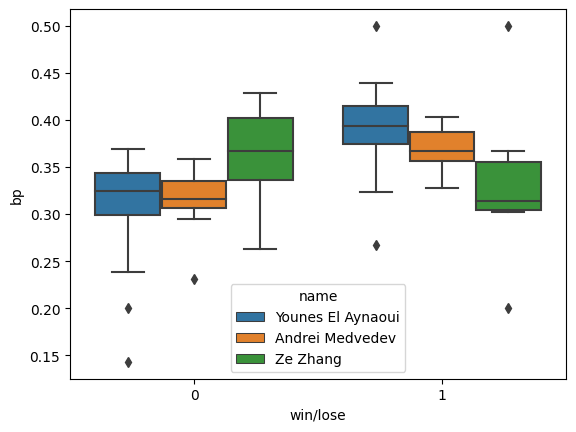

In [595]:
sns.boxplot(data=general, x='win/lose', y='bp', hue='name');

Для игроков Younes El Aynaoui и Andrei Medvedev доля выигранных брейкоинтов выше в победных матчах, у игрока Ze Zhang наблюдается обратная зависимость.

Проведем тест Шапиро для игроков, чтобы проверить распределение среднего количества выигранных брейкпоинтов на нормальность.

In [596]:
print(stats.shapiro(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 1)]['bp']))
print(stats.shapiro(general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 1)]['bp']))
print(stats.shapiro(general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 1)]['bp']))

ShapiroResult(statistic=0.963798463344574, pvalue=0.7035882472991943)
ShapiroResult(statistic=0.9597858190536499, pvalue=0.7690154910087585)
ShapiroResult(statistic=0.9265941381454468, pvalue=0.554068922996521)


p-значение больше 0.05 - признаки распределены нормально

Посмотрим на распределения рассматриваемых признаков.

C:\Temp\ipykernel_9288\1368687508.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 1)]['bp'],
C:\Temp\ipykernel_9288\1368687508.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(general[(general['name'] == 'Andrei Me

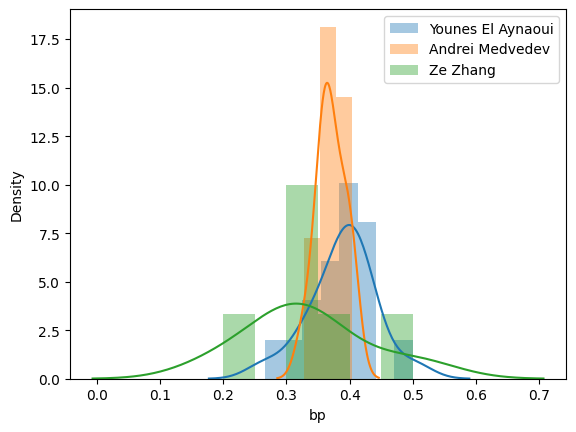

In [597]:
sns.distplot(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 1)]['bp'], 
             label='Younes El Aynaoui');
sns.distplot(general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 1)]['bp'], 
             label='Andrei Medvedev');
sns.distplot(general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 1)]['bp'], 
             label='Ze Zhang');
plt.legend();

Признаки распределены нормально, поэтому мы можем применить к ним однофакторный дисперсионный анализ ANOVA, чтобы сравнить 3 выборки между собой.

Проведем статистический анализ для выигранных матчей.

In [598]:
stats.f_oneway(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 1)]['bp'], 
               general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 1)]['bp'],
               general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 1)]['bp'])

F_onewayResult(statistic=2.205519016746149, pvalue=0.12719119825556957)

In [599]:
stats.f_oneway(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 1)]['bp'], 
               general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 1)]['bp'])

F_onewayResult(statistic=1.1498067682147721, pvalue=0.2934421182783212)

In [600]:
stats.f_oneway(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 1)]['bp'], 
               general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 1)]['bp'])

F_onewayResult(statistic=3.1373675568823476, pvalue=0.09103088480815516)

In [601]:
stats.f_oneway(general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 1)]['bp'],
               general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 1)]['bp'])

F_onewayResult(statistic=1.544439441853902, pvalue=0.23303511144802078)

Во всех проведенных тестах значение p-value > 0.05, что говорит о том, что различие среднего количества выигранных брейкпоинтов между игроками не является статистически значимым.

Аналогично рассмотрим проигранные матчи.

C:\Temp\ipykernel_9288\140267229.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 0)]['bp'],
C:\Temp\ipykernel_9288\140267229.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(general[(general['name'] == 'Andrei Medv

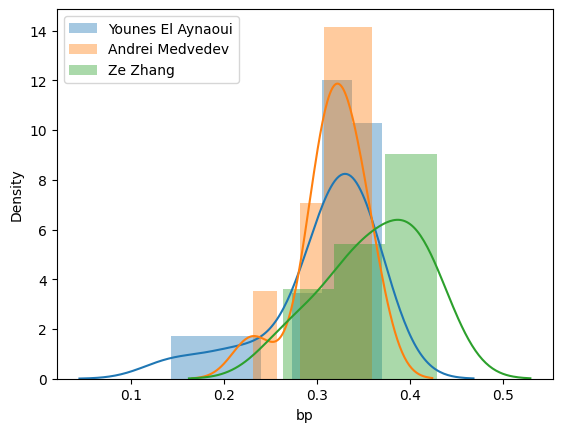

In [602]:
sns.distplot(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 0)]['bp'], 
             label='Younes El Aynaoui');
sns.distplot(general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 0)]['bp'], 
             label='Andrei Medvedev');
sns.distplot(general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 0)]['bp'], 
             label='Ze Zhang');
plt.legend();

In [603]:
print(stats.shapiro(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 0)]['bp']))
print(stats.shapiro(general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 0)]['bp']))
print(stats.shapiro(general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 0)]['bp']))

ShapiroResult(statistic=0.813624382019043, pvalue=0.0023812800645828247)
ShapiroResult(statistic=0.8827260732650757, pvalue=0.11266180127859116)
ShapiroResult(statistic=0.9452003836631775, pvalue=0.6121859550476074)


Тест Шапиро показал, что среднее количество выигранных брейкпоинтов для Younes EL Aynaoui распределено ненормально. Однако это отклонение некритично, поэтому к этим выборкам также применим однофакторный дисперсионный анализ.

In [604]:
stats.f_oneway(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 0)]['bp'], 
               general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 0)]['bp'],
               general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 0)]['bp'])

F_onewayResult(statistic=3.7295679988780157, pvalue=0.033727599386122034)

In [605]:
stats.f_oneway(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 0)]['bp'], 
               general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 0)]['bp'])

F_onewayResult(statistic=0.24790952162437996, pvalue=0.6225822319058918)

In [606]:
stats.f_oneway(general[(general['name'] == 'Younes El Aynaoui') & (general['win/lose'] == 0)]['bp'], 
               general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 0)]['bp'])

F_onewayResult(statistic=5.936091930331797, pvalue=0.021989790041783818)

In [607]:
stats.f_oneway(general[(general['name'] == 'Andrei Medvedev') & (general['win/lose'] == 0)]['bp'],
               general[(general['name'] == 'Ze Zhang') & (general['win/lose'] == 0)]['bp'])

F_onewayResult(statistic=5.307847050401648, pvalue=0.032691764042325294)

Проведенный анализ, что отклонение среднего количества выигранный брейкпоинтов для игрока Ze Zhang от показателей других игроков статичтически значимо. Для игроков Younes El Aynaoui и Andrey Medvedev различия в выигранных брейкпоинтах не является статичтисеки значимым.

## Задача 5
У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре. Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.

Создадим 2 признака: w_bpRate - доля выигранных брейкоинтов от всех выигранных за матч брейкпоинтов для победителя, l_bpRate - доля выигранных брейкпоинтов от всех выигранных за матч брейкпоинтов для проигравшего.

In [610]:
df['w_bpRate'] = df['w_bpSaved'] / (df['w_bpSaved'] + df['l_bpSaved'])
df['l_bpRate'] = df['l_bpSaved'] / (df['w_bpSaved'] + df['l_bpSaved'])

Объединим данные о победителях (id, доля выигранных брейкпоинтов в одной таблице).

In [611]:
win_players = df[['winner_id', 'w_bpRate']]
win_players['win/lose'] = 1
win_players.columns = ['player_id', 'bpRate', 'win/lose']
win_players = win_players.replace([np.inf, -np.inf], np.nan).dropna()

C:\Temp\ipykernel_9288\573911187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_players['win/lose'] = 1


Объединим данные о проигравших (id, доля выигранных брейкпоинтов в одной таблице).

In [612]:
lose_players = df[['loser_id', 'l_bpRate']]
lose_players['win/lose'] = 0
lose_players.columns = ['player_id', 'bpRate', 'win/lose']
lose_players = lose_players.replace([np.inf, -np.inf], np.nan).dropna()

C:\Temp\ipykernel_9288\2569725462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lose_players['win/lose'] = 0


Объединим данные о победивших и проигравших игроках.

In [613]:
players = pd.concat([win_players, lose_players]).reset_index(drop=True)
players = players.dropna(how='any', axis=0)

Разделим долю выигранных брейкпоинтов на 2 категории: выше и ниже медианы (столбец many_bp).

In [614]:
players['many_bp'] = players['bpRate'].apply(lambda x: 1 if x > 0.5 else 0)

Проверим, связана ли победа игрока с долей выигранных за матч брейкпоинтов. Для этого вычислим корреляцию Мэтьюса, т.к. исследуемые признаки являются бинарными.

In [616]:
matthews_corrcoef(players['win/lose'], players['many_bp'])

-0.2819380496417879

Коэициент корреляции < 0.3 (по абсолютному значению), что говорит оботсутствии связи между долей выигранных за матч брейкпоинтов и победой игрока.